In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
%matplotlib inline

sns.set(font_scale=1, style='whitegrid', palette='Set3')

In [54]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)
engine.dispose()

In [3]:
life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


# Data exploration, dealing with the missing values

In [4]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

Variables all appear to have the appropriate data type. Time to handle the missing values.

In [5]:
#Remove leading and trailing white space from columns

columns = []
for i in range(len(life_df.columns)):
    columns.append(life_df.columns[i].strip())
    
life_df.columns = columns

In [55]:
print('Percentages of null data per column variable')
print('=============================================')
life_df.isnull().sum()/life_df.isnull().count()*100

Percentages of null data per column variable


Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

Most data is present, with the exceptions of Hepatitis B, GDP, and Population. Next lets check where the missing data is coming from, presumably it should be missing either by year or by country.

In [7]:
life_df.groupby('Year')[('Hepatitis B', 'GDP', 'Population', 'Total expenditure')].mean()

,Hepatitis B,GDP,Population,Total expenditure
Year,,,,
2000,74.035294,4708.515191,9.440444e+06,5.585475
2001,73.957895,4854.527638,1.007057e+07,5.599609
2002,76.522124,4599.303043,6.625328e+06,5.687989
2003,74.099237,4774.835677,1.015988e+07,5.827444
2004,77.985507,7055.889709,1.685299e+07,5.859111
2005,80.911565,7249.787557,1.828185e+07,5.920722
2006,81.894040,7347.033143,1.536564e+07,5.699000
2007,81.584906,8537.243114,1.853530e+07,5.631056
2008,83.644172,10604.040364,9.487742e+06,5.723056


Every year has data available, let's check by country.

In [8]:
life_df.groupby('Country')[('Hepatitis B', 'GDP', 'Population')].mean()

,Hepatitis B,GDP,Population
Country,,,
Afghanistan,64.562500,340.015425,9.972260e+06
Albania,98.000000,2119.726679,6.969116e+05
Algeria,78.000000,2847.853392,2.164983e+07
Angola,70.222222,1975.143045,1.014710e+07
Antigua and Barbuda,98.266667,9759.305728,NaN
Argentina,81.285714,6998.575103,2.012120e+07
Armenia,87.562500,1999.986318,1.015165e+06
Australia,93.400000,34637.565047,4.587010e+06
Austria,81.062500,33827.476309,6.474880e+06


Multiple countries have data missing. Due to the broad range of countries available, let's impute missing values with mean values by year and by status. 

In [9]:
life_df2 = life_df.copy(deep=True)

variables = life_df.columns[3:]
#variables = ['Life expectancy', 'Adult Mortality']
status = ['Developing', 'Developed']


#Loop through variables, years, and country status. If null, replace with mean for that status group and year

for variable in variables:
    for i in range(2000,2016):
        for s in status:
            mean = life_df.loc[(life_df.Status == s) & (life_df.Year == i),variable].mean()
            life_df2.loc[(life_df2.Status == s) & 
                         (life_df2.Year == i),variable] = life_df2.loc[(life_df2.Status == s) & 
                                                                       (life_df2.Year == i),variable].fillna(mean)

In [10]:
print('Percentages of null data per column variable after imputation')
print('=============================================================')
life_df2.isnull().sum()/life_df2.isnull().count()*100

Percentages of null data per column variable after imputation


Country                            0.000000
Year                               0.000000
Status                             0.000000
Life expectancy                    0.000000
Adult Mortality                    0.000000
infant deaths                      0.000000
Alcohol                            0.000000
percentage expenditure             0.000000
Hepatitis B                        0.000000
Measles                            0.000000
BMI                                0.000000
under-five deaths                  0.000000
Polio                              0.000000
Total expenditure                  1.089176
Diphtheria                         0.000000
HIV/AIDS                           0.000000
GDP                                0.000000
Population                         0.000000
thinness  1-19 years               0.000000
thinness 5-9 years                 0.000000
Income composition of resources    0.000000
Schooling                          0.000000
dtype: float64

Total expenditure still has some data missing, it must be missing for one of the years in one of the status groups.

In [11]:
life_df2.groupby(['Year','Status'])['Total expenditure'].count()

Year  Status    
2000  Developed      32
      Developing    151
2001  Developed      32
      Developing    151
2002  Developed      32
      Developing    151
2003  Developed      32
      Developing    151
2004  Developed      32
      Developing    151
2005  Developed      32
      Developing    151
2006  Developed      32
      Developing    151
2007  Developed      32
      Developing    151
2008  Developed      32
      Developing    151
2009  Developed      32
      Developing    151
2010  Developed      32
      Developing    151
2011  Developed      32
      Developing    151
2012  Developed      32
      Developing    151
2013  Developed      32
      Developing    161
2014  Developed      32
      Developing    151
2015  Developed       0
      Developing    151
Name: Total expenditure, dtype: int64

Aha, there is no data for Total expenditure in 2015 for Developed countries. Let's impute the mean values for all years for developed countries here.

In [12]:
#Imputing mean Total expenditure values for developed countries

life_df2.loc[:,'Total expenditure'] = life_df2['Total expenditure'].fillna(
    life_df2.loc[life_df2['Status']=='Developed', 'Total expenditure'].mean())

In [13]:
print('Percentages of null data per column variable after imputation')
print('=============================================================')
life_df2.isnull().sum()/life_df2.isnull().count()*100

Percentages of null data per column variable after imputation


Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness  1-19 years               0.0
thinness 5-9 years                 0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

# Checking for outliers

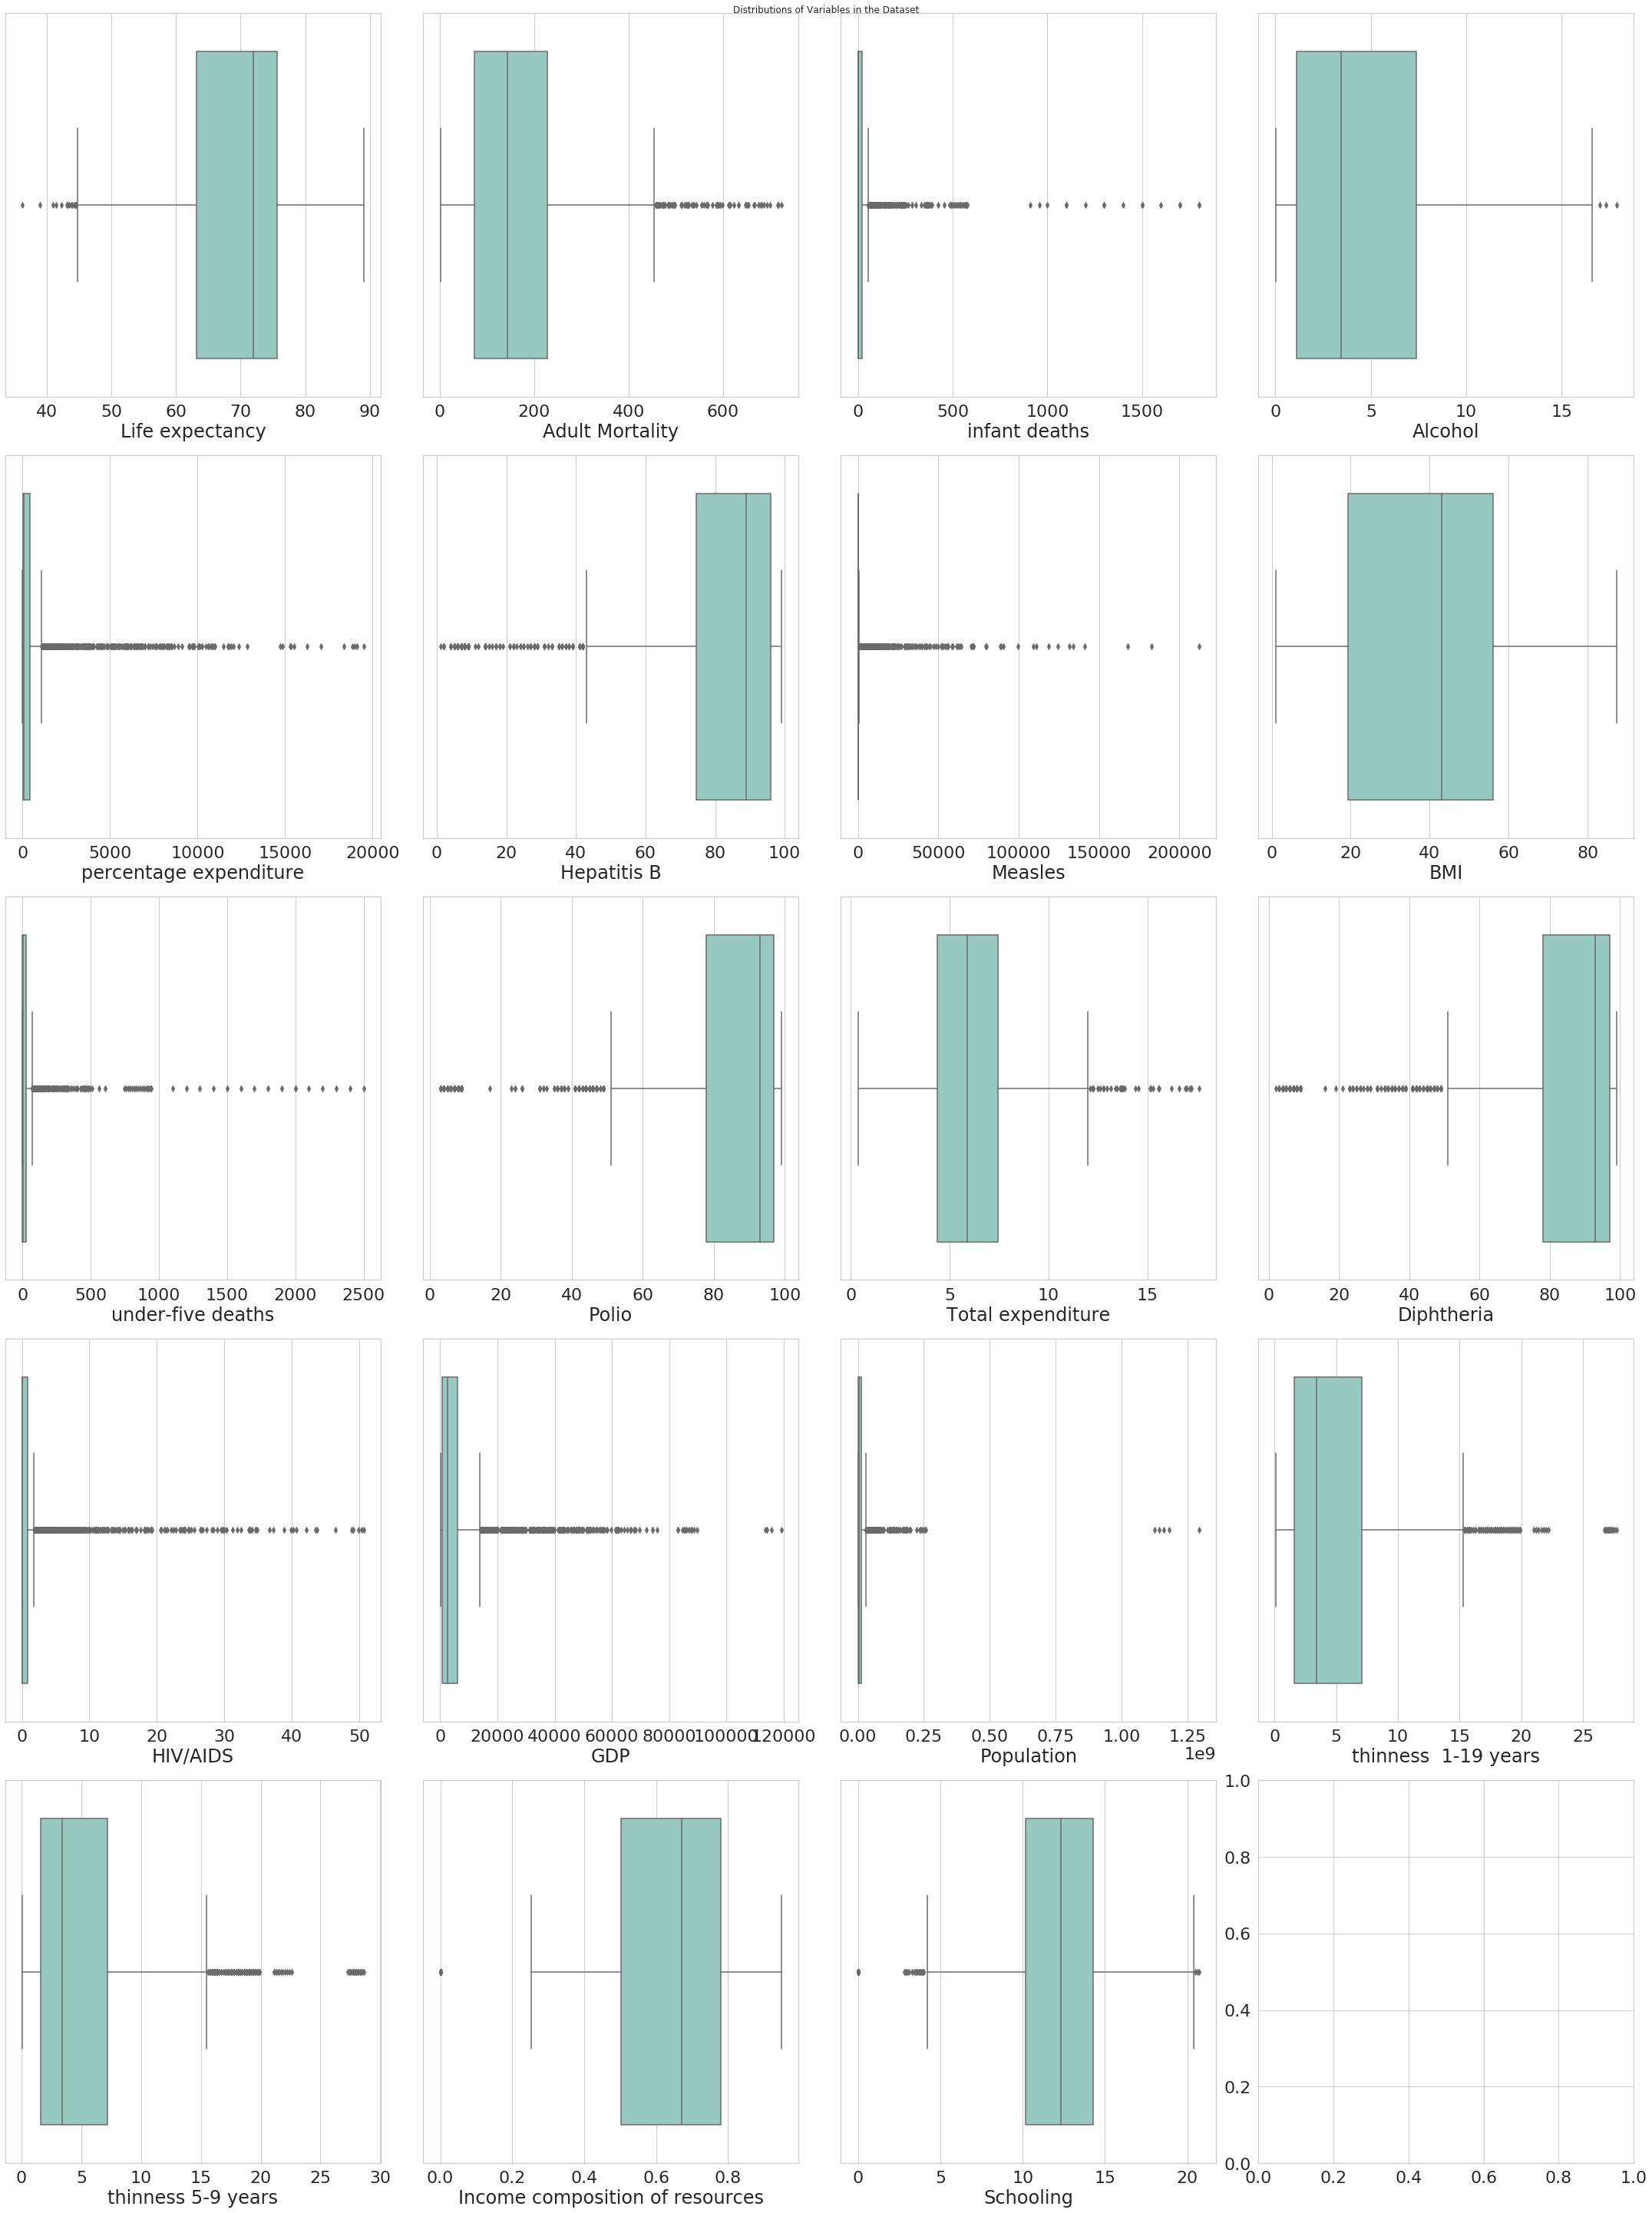

In [14]:
#Create list of variables to plot

variables = life_df.columns[3:]

#Create figure object and set seaborn defaults

fig, axes = plt.subplots(5,4,figsize=(30,40))

for i in range(5):
    for j in range(4):
        try:
            sns.boxplot(life_df2[variables[i*4+j]], ax=axes[i,j])
            axes[i,j].set_xticklabels(fontdict={'fontsize':12})
        except:
            print

plt.suptitle('Distributions of Variables in the Dataset', y=1)
plt.tight_layout()
plt.show()

Using the dataset information provided by Kaggle, we can see if there are any apparent erroneous values in the boxplots above.

Suspicious variable categories

1. Incorrect data entry (a few variables outside of the range of the data) 
        -Infant deaths, Measles, Under 5 deaths should be between 1-1000
2. Incorrect scale of data (the data values do fall within an expected range)
        -Both Percentage expenditure and BMI values are extremely high


Process for handling suspicious variables

    1. Variables in category 1 will have their outliers transoformed to mean values for each variable
    2. Variables in category 2 will not be adjusted, but caution must be taken when interpreting these data

In [15]:
#Change erroneous data to variable means

cat1_vars = ['infant deaths', 'Measles', 'under-five deaths']

for var in cat1_vars:
    for i in range(len(life_df2[var])):
        if life_df2.loc[i,var] > 1000:
            life_df2.loc[i,var] = life_df2.loc[:,var].mean()

For now, I will take a step back to check bivariate relationships with an emphasis on the life expectancy variable. Because we do not meet many of the assumptions for a Pearson's correlation, I will use a Spearman's Rank correlation to test for the presence of any monotonic relationships in our data.

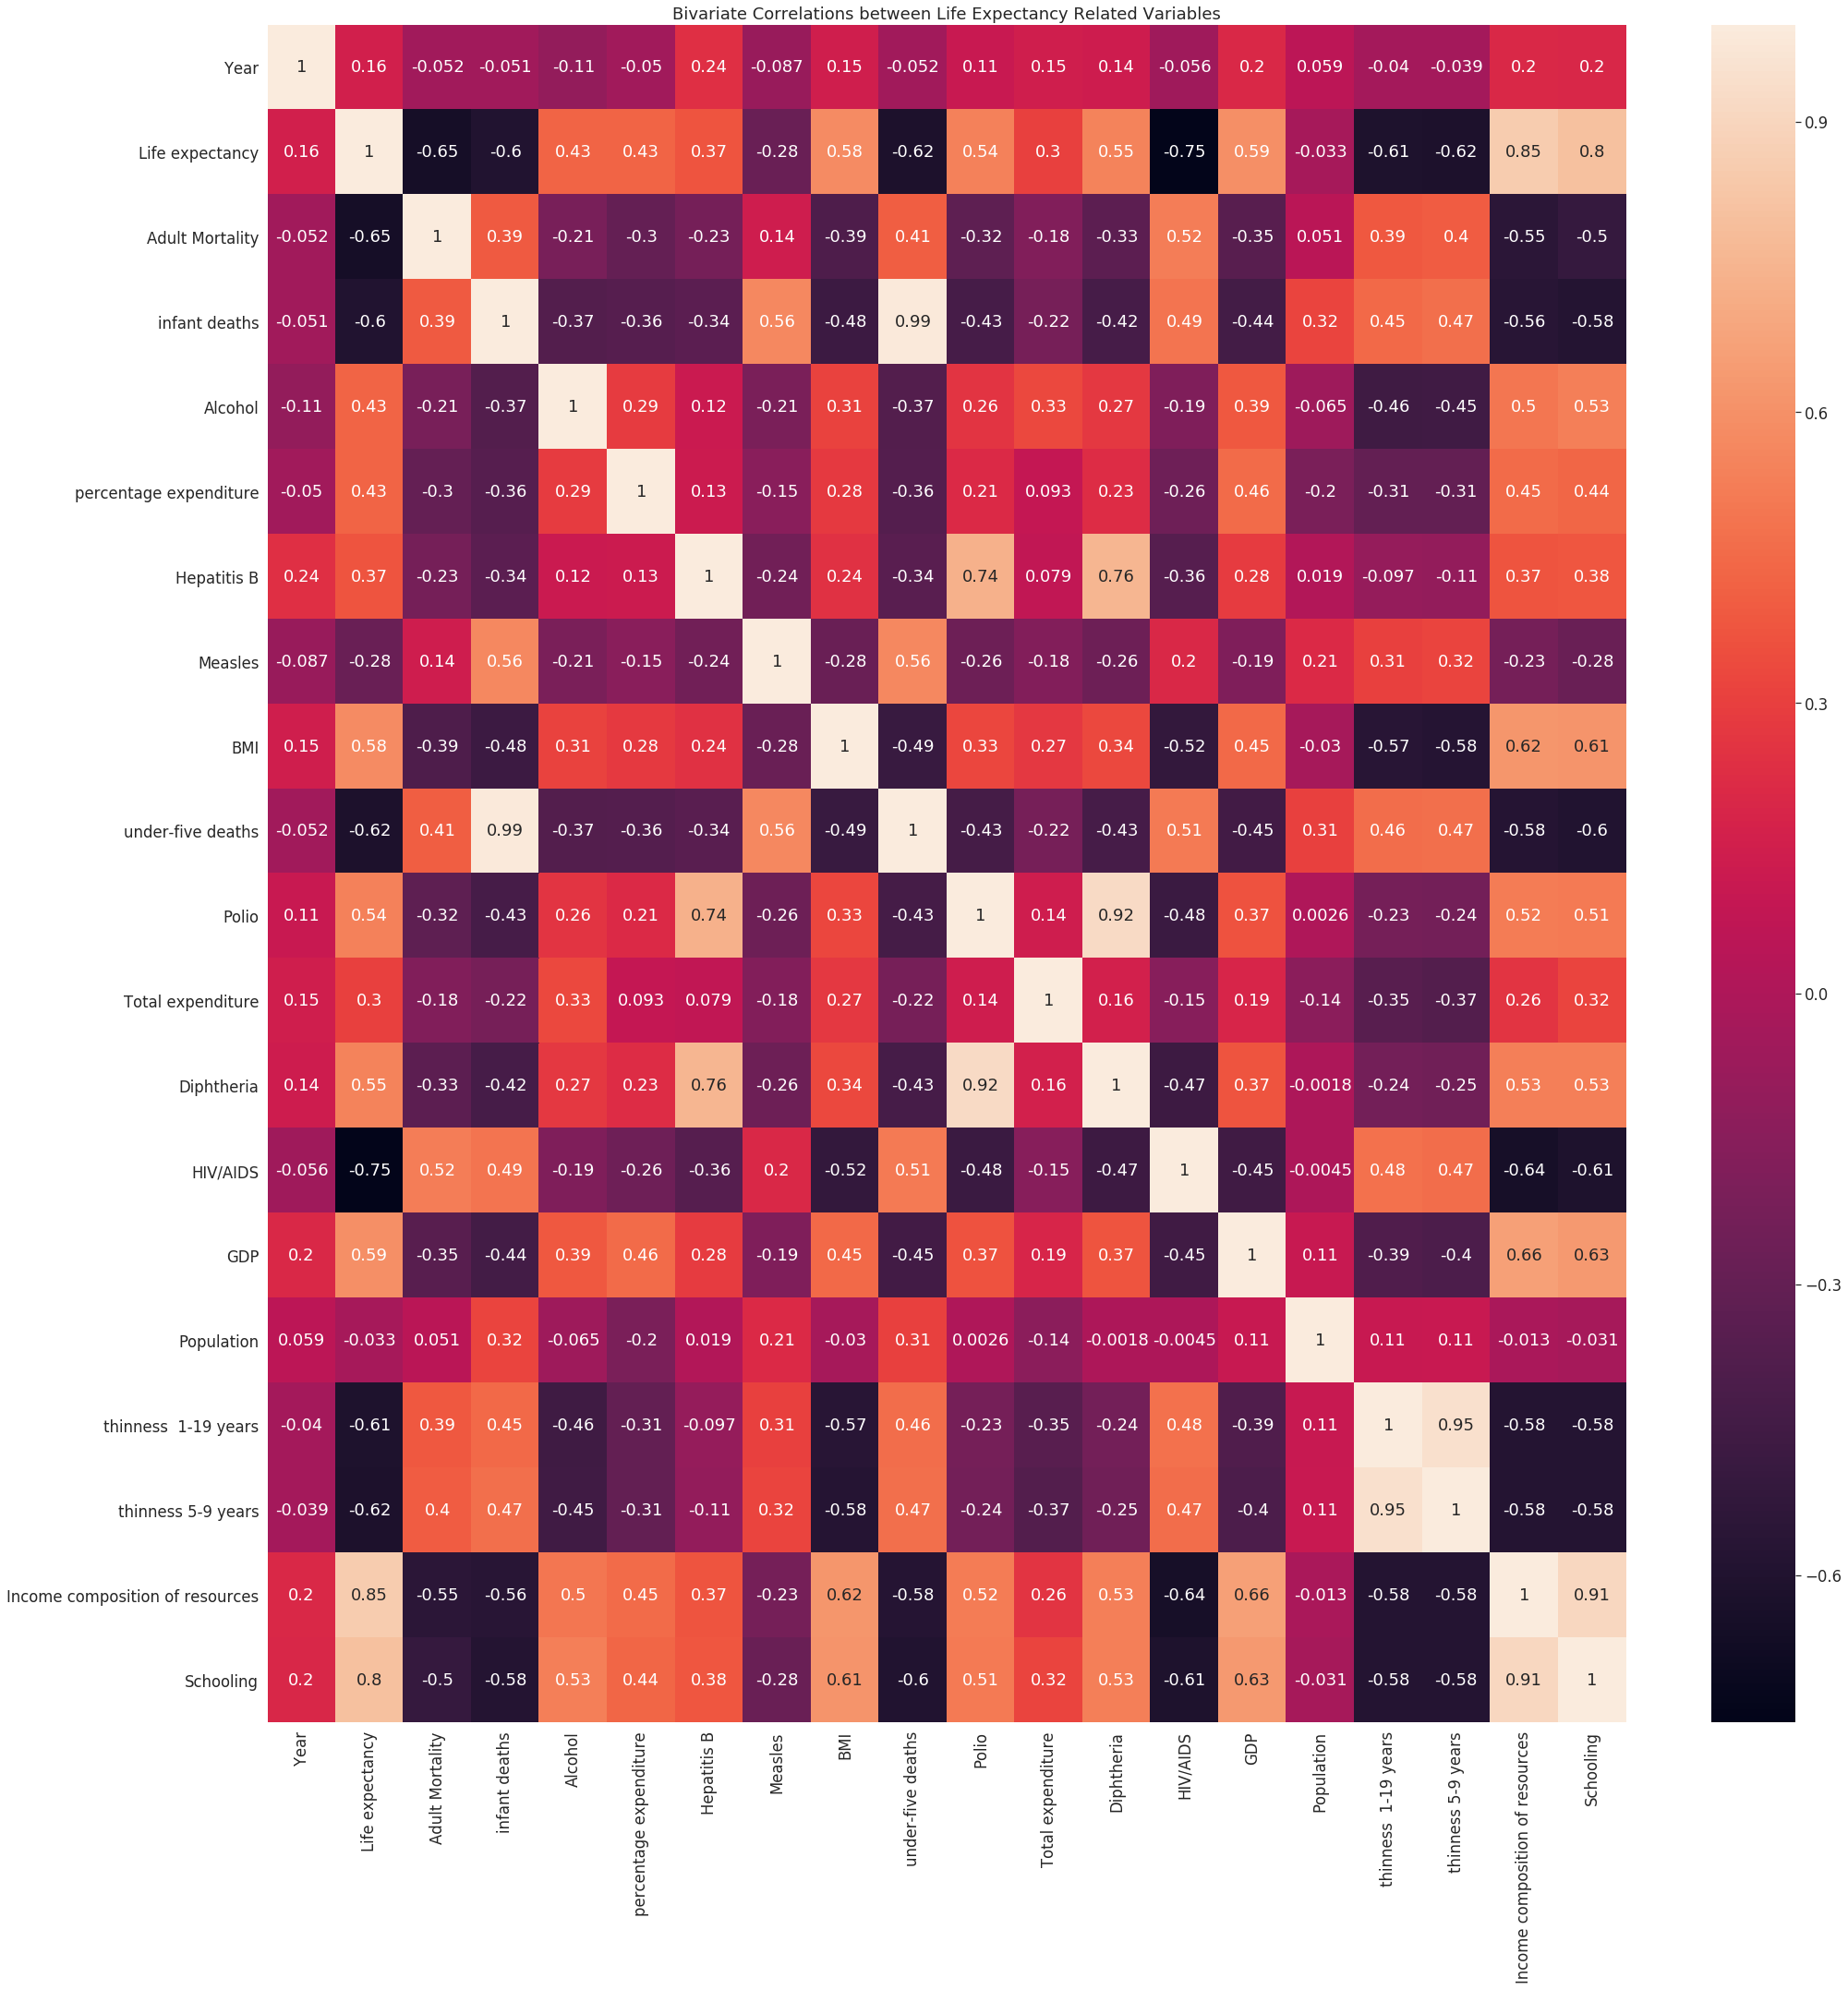

In [16]:
#Create correlation matrix, figure object, and set seaborn styles
corrs = life_df2.corr(method='spearman')

plt.figure(figsize=(30,30))
sns.set(font_scale=1.5)

sns.heatmap(corrs,annot=True)

plt.tight_layout()
plt.title('Bivariate Correlations between Life Expectancy Related Variables')
plt.show()

Not surprinsigly, numerous correlations are present. The strongest positive correlations for Life expectancy come from Income composition of resources and Schooling. The strongest negative correlation is Adult Mortality (big surprise here!), followed by HIV/AIDS. Next I will begin to select features for the statistical modeling of Life expectancy.

# Feature engineering

Steps:

    1. Explore the possiblility of PCA for immunizations (Hepatitis B, Polio, Diptheria) and young deaths (HIV/AIDS, Infant mortality, under-five deaths)
    2. Thinness will be included for just the thinness 1-19 variable as the two thinness variables are too highly correlated for PCA
    3. While infant mortality is important, we will include under-five deaths as it encompasses more of the population and is very highly correlated with infant mortality.
    4. Include Scholing and Income composition of resources will be included
    5. Final features will include: Schooling, Income composition of resources, principal components of immunizations, principal components of young deaths

PCA assumptions- continuous variables, linear relationship between variables, sufficient sample size, suitable correlations, no significant ouliers

    -We already know the data is continuous, sample size is large, and the data are correlated
    -Need to test for linearity and adjust for outliers

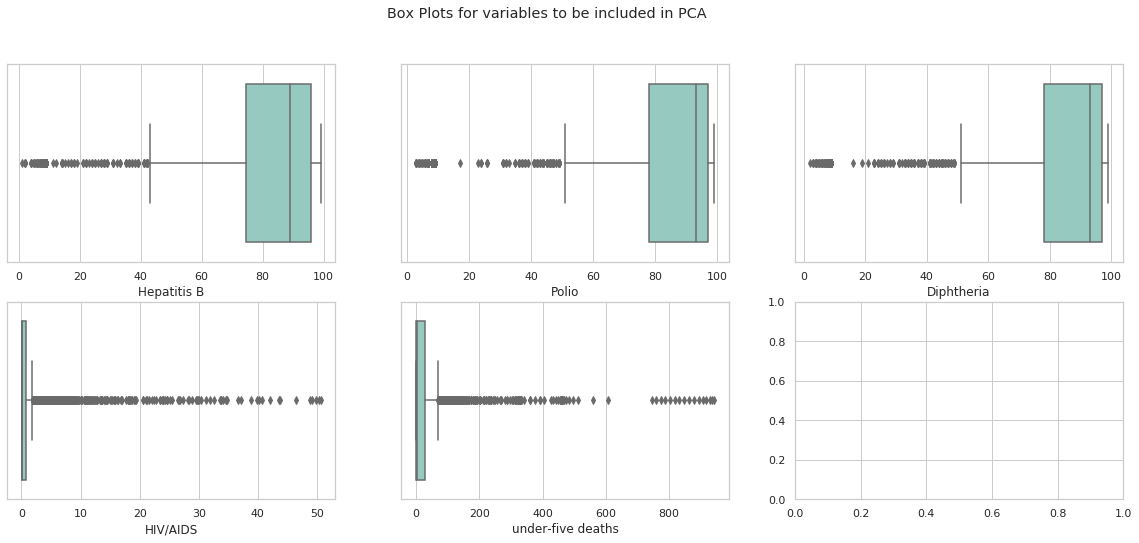

In [42]:
# Plot variables included in PCA to determine how to normalize
# Note that the algorithm in the axes[] brackets simply sorts the plots into 2 rows of 4 columns
sns.set(font_scale=1, style='whitegrid', palette='Set3')
pca_vars = ['Hepatitis B', 'Polio', 'Diphtheria', 'HIV/AIDS', 'under-five deaths']

fig, axes = plt.subplots(2,3,figsize=(20,8))

for i in range(len(pca_vars)):
    sns.boxplot(life_df2[pca_vars[i]], ax=axes[int(np.floor(i/3)),int(i-(np.floor(i/3)*3))])
 
plt.suptitle('Box Plots for variables to be included in PCA')
plt.show()

There are significant numbers of outliers in these variables, which is an issue for PCA. First lets perform a transformation of the data.

In [18]:
#Create new df with box-cox transormed data

box_transformations = []

for var in variables:
    life_df2[var] = life_df2[var] + 0.01
    box_transformations.append(stats.boxcox(life_df2[var])[0])
    
box_transformations = pd.DataFrame(box_transformations).transpose()

In [19]:
box_transformations.columns = variables

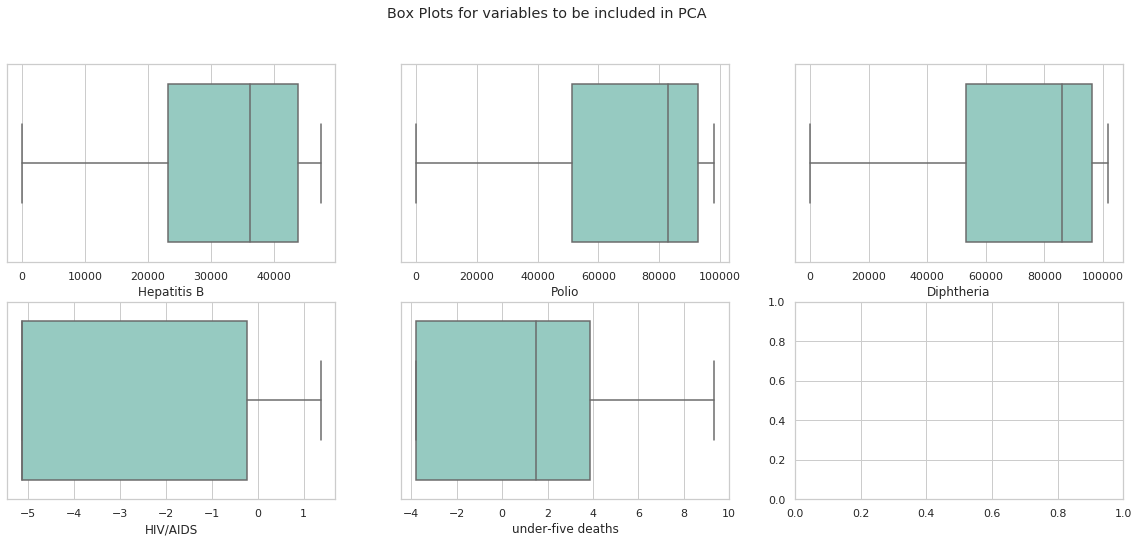

In [34]:
# Plot variables included in PCA to determine if outliers were removed
# Note that the algorithm in the axes[] brackets simply sorts the plots into 2 rows of 4 columns

fig, axes = plt.subplots(2,3,figsize=(20,8))


for i in range(len(pca_vars)):
    sns.boxplot(box_transformations[pca_vars[i]], ax=axes[int(np.floor(i/3)),int(i-(np.floor(i/3)*3))])
 
plt.suptitle('Box Plots for variables to be included in PCA')
plt.show()

After box-cox transformation, no outliers remain. Now let's check linearity by using a scatterplot for immunizations and then young deaths.

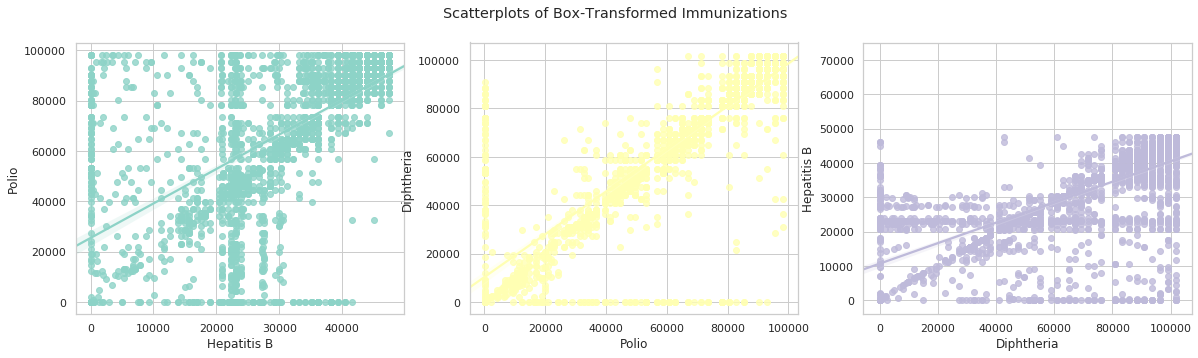

In [35]:
#immunizations

imm_vars = ['Hepatitis B', 'Polio', 'Diphtheria']

fig, axes = plt.subplots(1,3,figsize=(20,5))

for i in range(len(imm_vars)):
    sns.regplot(x=imm_vars[i],
               y=imm_vars[(i+1)%3],
               data=box_transformations,
               ax=axes[i])

plt.suptitle('Scatterplots of Box-Transformed Immunizations')
plt.show()

While there appears to be some part of the data that contains a linear relationship, there is a lot of noise. This is especially true in the Hepatitis B variable. I will proceed with the PCA with the exclusion of the Hepatitis B variable.

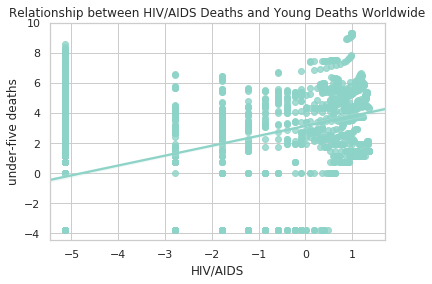

In [36]:
#young deaths

sns.regplot(x='HIV/AIDS',y='under-five deaths',data=box_transformations)

plt.title('Relationship between HIV/AIDS Deaths and Young Deaths Worldwide')
plt.show()

Again, the data hints at a relationship but it is extremely noisy. A PCA here would be innapropriate. I will include HIV/AIDS and under-five deaths as seperate features in the model.

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Standardize the Polio and Diphtheria variables

sc = StandardScaler()
X = sc.fit_transform(box_transformations.loc[:,('Polio','Diphtheria')])

In [24]:
#Conduct PCA, test 1st component

pca = PCA()
pca.fit(X)
pca.explained_variance_ratio_

array([0.92482149, 0.07517851])

92% of the variance is explained by the 1st principal component, let's include this first component in our final model.

In [25]:
#Save 1st principal component

pca = PCA(n_components=1)
immunizations_pc1 = pca.fit_transform(X)

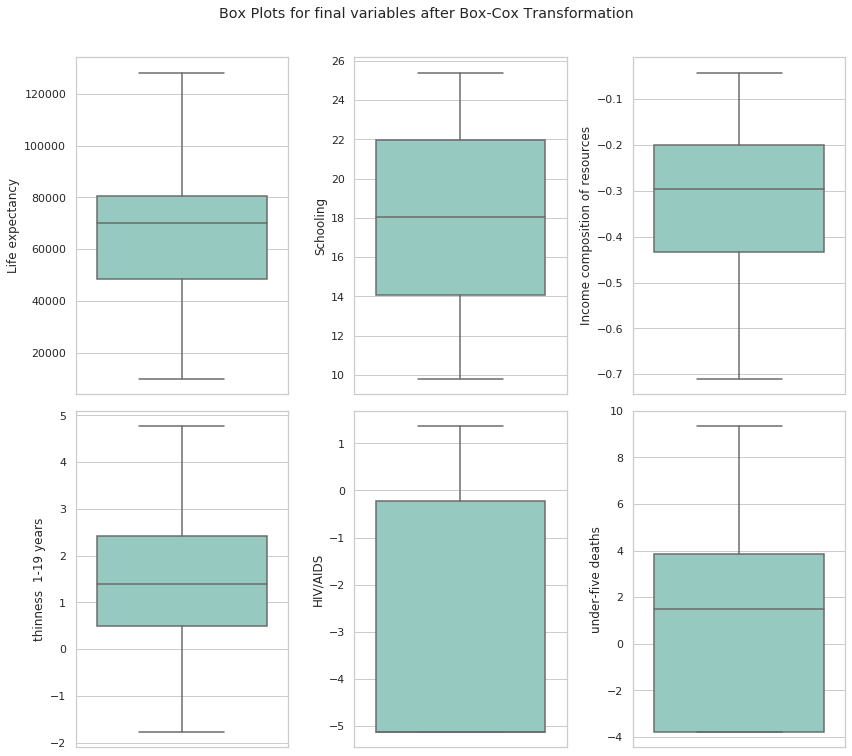

In [52]:
final_vars = ('Life expectancy','Schooling','Income composition of resources','thinness  1-19 years', 'HIV/AIDS', 'under-five deaths')
                                                 
fig, axes = plt.subplots(2,3,figsize=(12,10))

for i in range(len(final_vars)):
    sns.boxplot(box_transformations[final_vars[i]], 
                orient='v',
                ax=axes[int(np.floor(i/3)),int(i-(np.floor(i/3)*3))])
 
plt.suptitle('Box Plots for final variables after Box-Cox Transformation', y=1.05)
plt.tight_layout()
plt.show()

In [27]:
# Schooling still has outliers, lets winsorize these

box_transformations['Schooling'] = stats.mstats.winsorize(box_transformations['Schooling'],0.1)

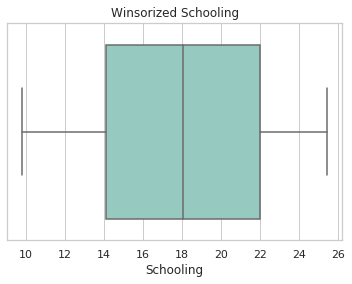

In [38]:
sns.boxplot(box_transformations['Schooling'])
plt.title('Winsorized Schooling')
plt.show()

In [39]:
#Add the remaining features to the final_df 

final_df = pd.DataFrame(box_transformations.loc[:,final_vars])
final_df['immunizations_pc1'] = immunizations_pc1

In [40]:
final_df.head()

,Life expectancy,Schooling,Income composition of resources,thinness 1-19 years,HIV/AIDS,under-five deaths,immunizations_pc1
0,52301.147937,13.901700,-0.450949,3.871236,-5.134589,5.382642,2.532808
1,41424.191937,13.718475,-0.453188,3.902375,-5.134589,5.434760,2.079749
2,41424.191937,13.535730,-0.457649,3.922900,-5.134589,5.485244,1.913294
3,40639.758656,13.353468,-0.462825,3.943241,-5.134589,5.550190,1.666623
4,40057.811496,12.809615,-0.469434,3.973418,-5.134589,5.612634,1.600639


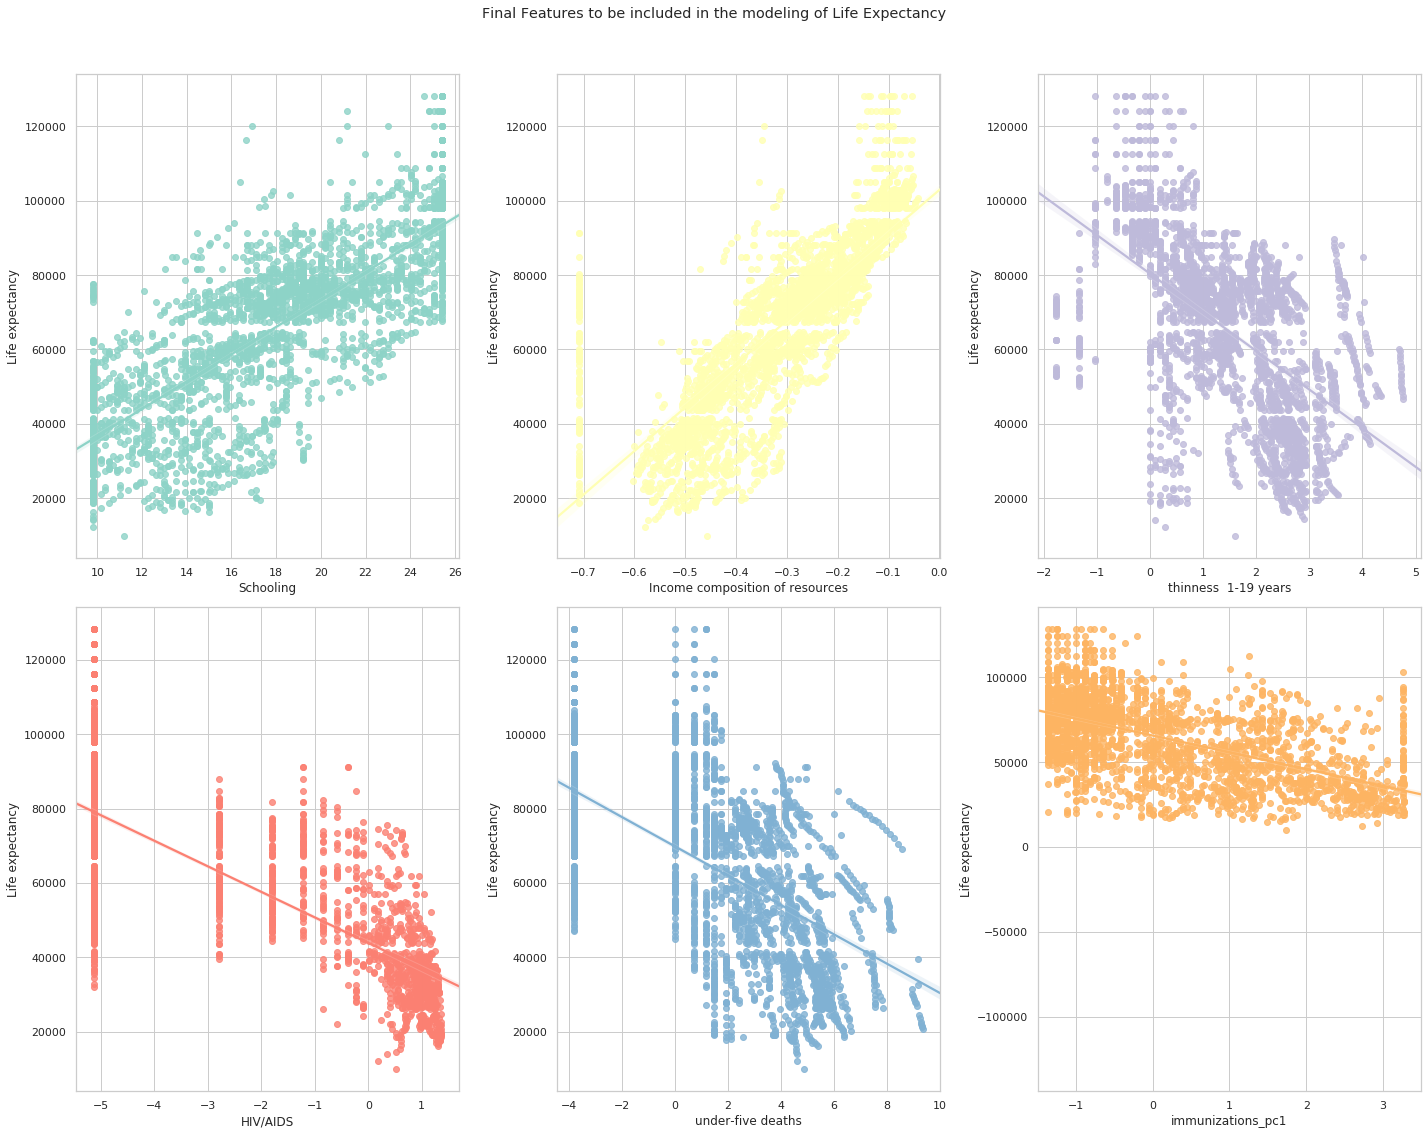

In [50]:
fig, axes = plt.subplots(2,3,figsize=(20,15))

for i in range(len(final_df.columns)-1):
    sns.regplot(x=final_df.columns[i+1],
               y='Life expectancy',
               data=final_df,
               ax=axes[int(np.floor(i/3)),int(i-(np.floor(i/3)*3))])

axes[1,2].set(xlim=(-1.5,3.5))
plt.suptitle('Final Features to be included in the modeling of Life Expectancy', y=1.05)
plt.tight_layout()
plt.show()